# 🕷️  E-commerce data analysis - linear regression 🕷️

In this task, we are going to analyze e-commerce data for customers who purchase clothes and try to answer the question of whether the yearly amount of money spent is correlated with different factors such as average session length, time spent on the app, time spent on the website, and length of membership. We will check if all factors are crucial for forecasting the yearly spent money and build a model to help the firm choose which factor to develop in the future.

Our main tool is going to be **Linear Regression** and **LASSO** as regularization factor.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from scipy.stats import pearsonr

import math
import warnings

warnings.filterwarnings("ignore")

## 1. Data cleaning 

In [2]:
data = pd.read_csv('Ecommerce_Customers.csv')

In [3]:
data = data.drop_duplicates()
data.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


e are going to drop the **Email**, **Address**, and **Avatar** columns as they do not provide any information to the model.

In [4]:
data.drop(['Email', 'Address', 'Avatar'], axis = 'columns', inplace = True)
data_clean = data.copy()

In [5]:
data_clean.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,33.053194,12.052488,37.060445,3.533462,499.314038
std,0.992563,0.994216,1.010489,0.999278,79.314782
min,29.532429,8.508152,33.913847,0.269901,256.670582
25%,32.341822,11.388153,36.349257,2.930450,445.038277
50%,33.082008,11.983231,37.069367,3.533975,498.887875
75%,33.711985,12.753850,37.716432,4.126502,549.313828
max,36.139662,15.126994,40.005182,6.922689,765.518462


In [6]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Avg. Session Length   500 non-null    float64
 1   Time on App           500 non-null    float64
 2   Time on Website       500 non-null    float64
 3   Length of Membership  500 non-null    float64
 4   Yearly Amount Spent   500 non-null    float64
dtypes: float64(5)
memory usage: 19.7 KB


Now the data is ready for further statistical analysis.

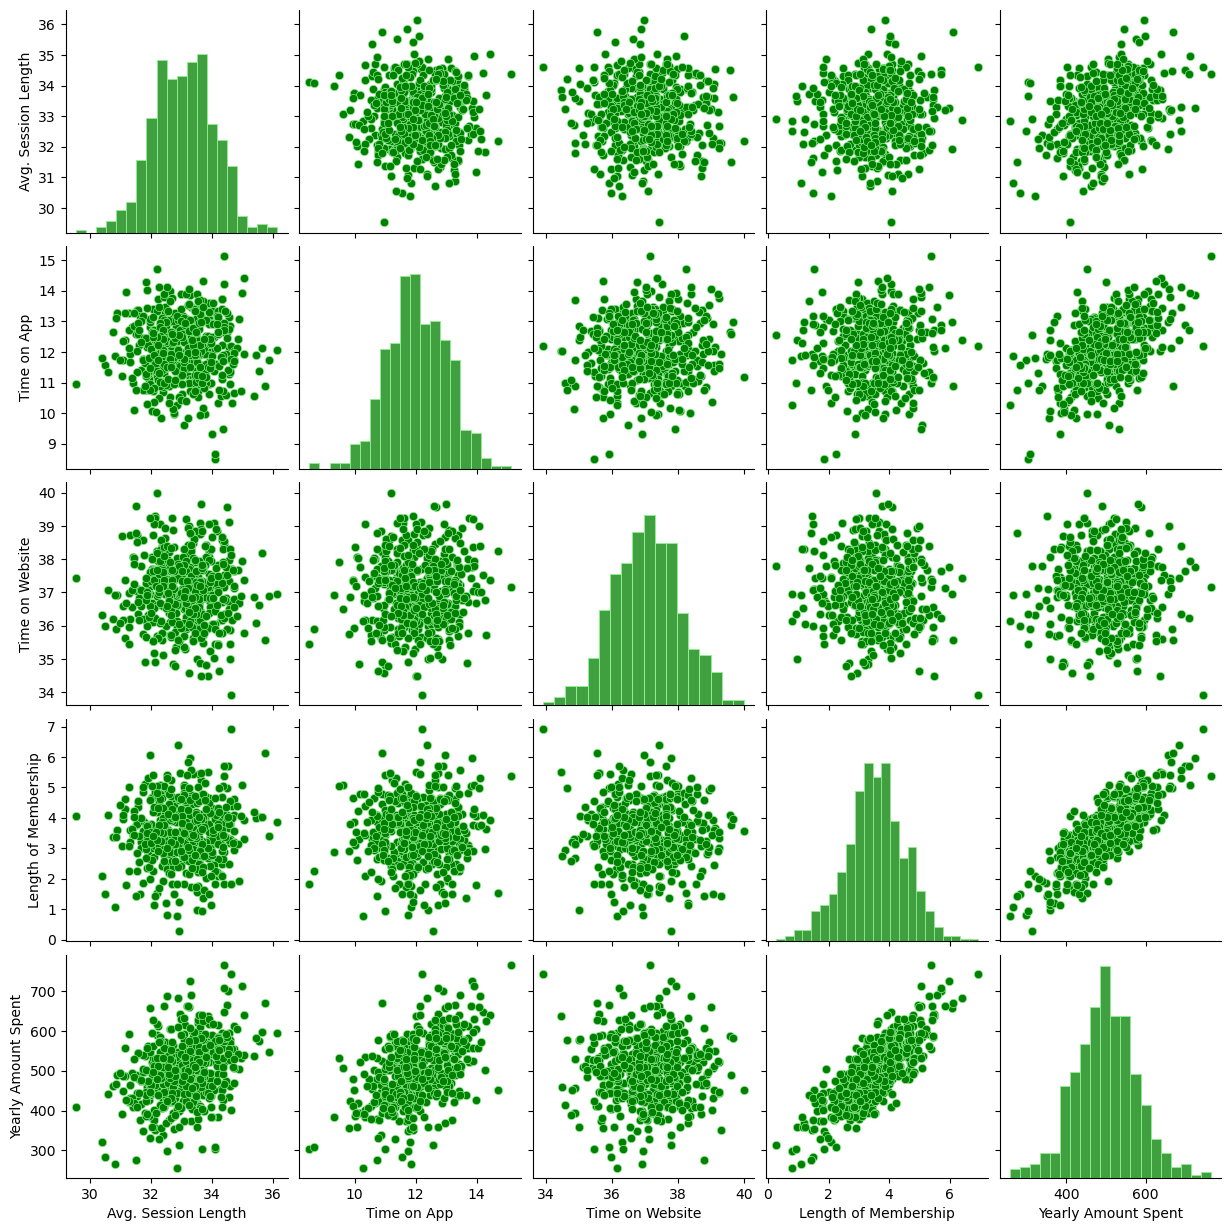

In [7]:
sns.pairplot(data_clean, plot_kws = {'color': 'green', 'edgecolor': 'lightgreen'}, diag_kws = {'color': 'green', 'edgecolor': 'lightgreen'})
plt.show()

The pairplot reveals a robust linear correlation between **Length of Membership** and **Yearly Amount Spent**. However, for other variables, no discernible relationships stand out.

Moreover, while our variables appear to exhibit a normal distribution, we validate this assumption using the Shapiro-Wilk test. This test is crucial for assessing the independence assumption in linear regression.

In [8]:
normality_test = pd.DataFrame(columns=['Statistic', 'p-value'], index=data_clean.columns)

for column in data_clean.columns:
    stat, p_value = stats.shapiro(data_clean[column])
    normality_test.loc[column] = [stat, p_value]

print(normality_test)

                     Statistic   p-value
Avg. Session Length   0.997658  0.716786
Time on App           0.997193  0.554851
Time on Website       0.998425  0.936611
Length of Membership  0.996185  0.274341
Yearly Amount Spent   0.996136  0.264331


Here, all p-values are greater than 0.05, indicating no statistical significance to reject the null hypothesis that variables follow a normal distribution. Therefore, we can assume that all our variables are normally distributed.

Finally, we will examine Q-Q plots for each variable to confirm these results.

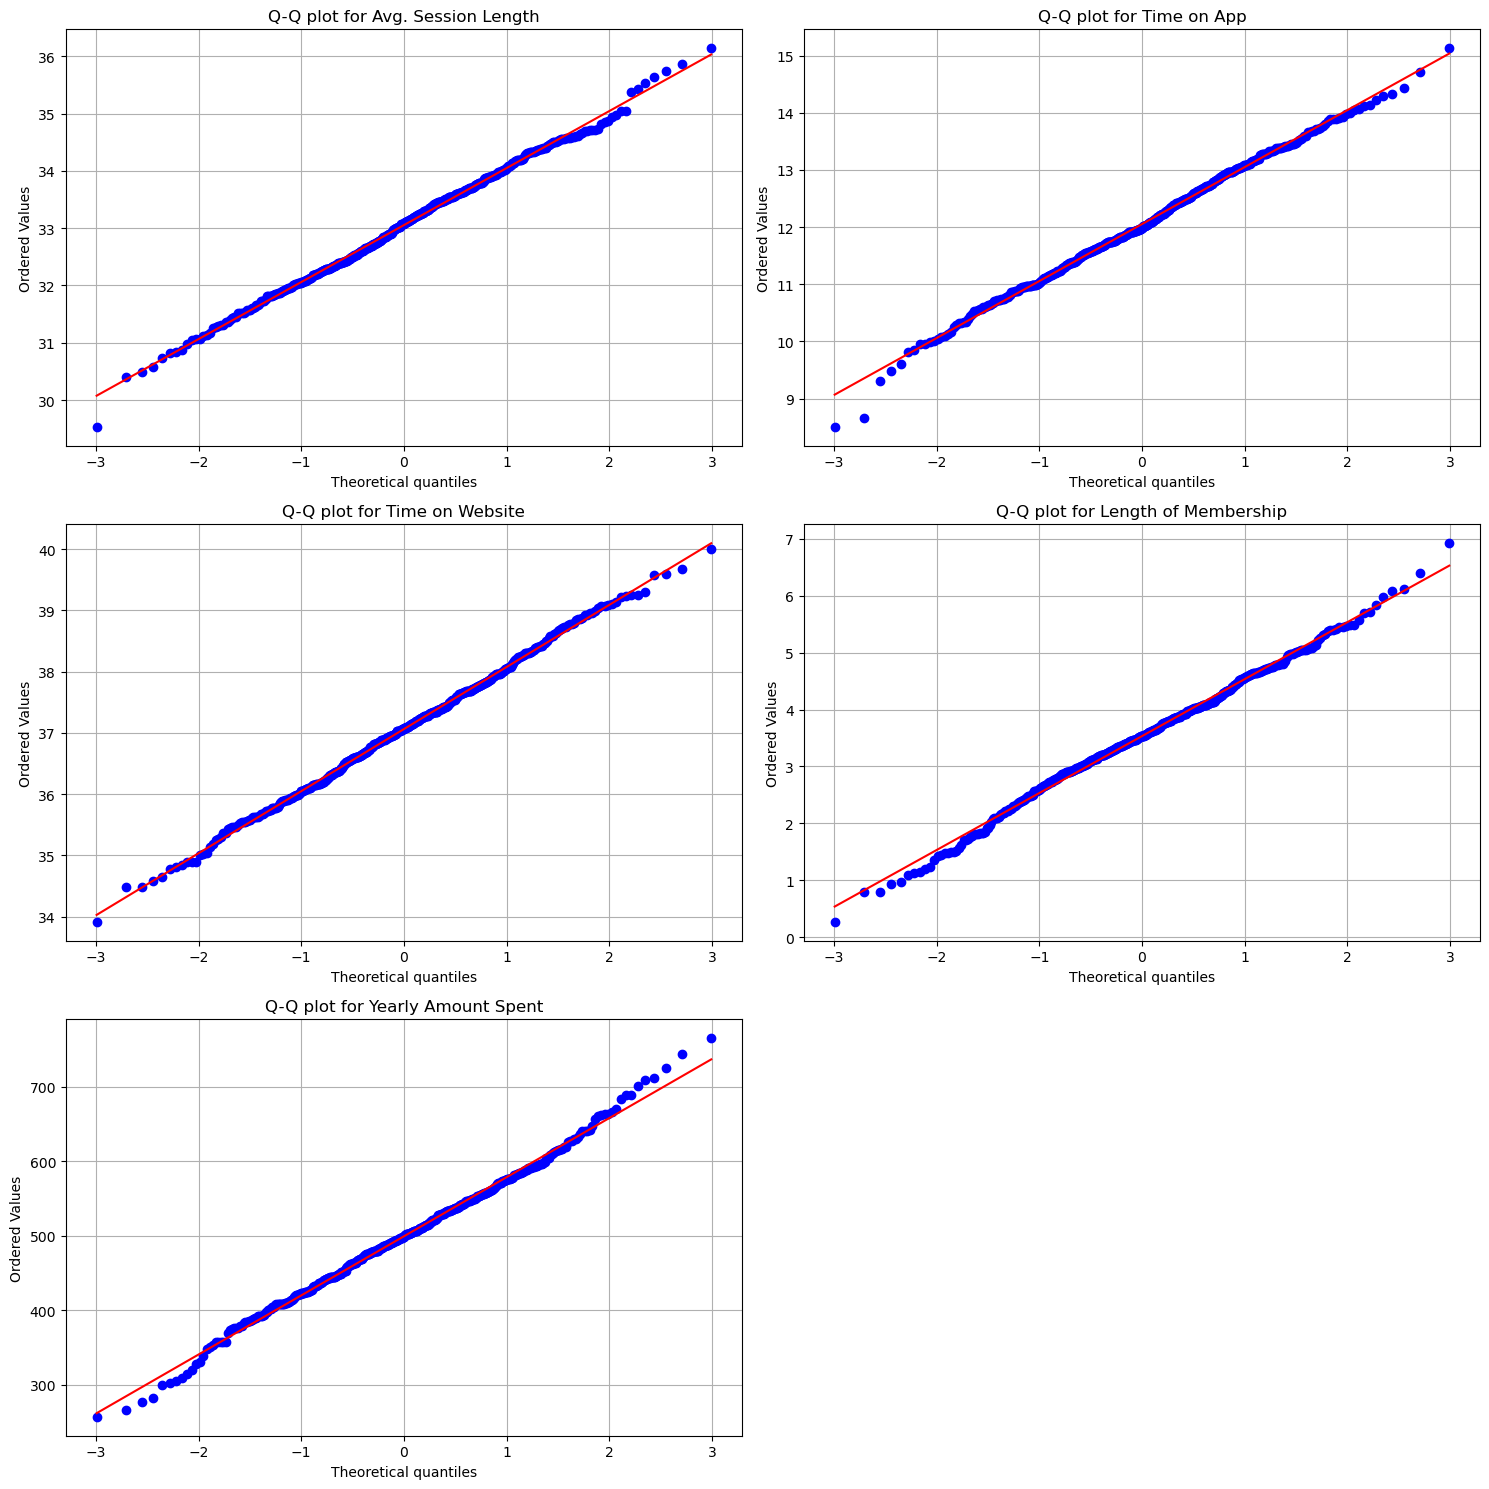

In [9]:
num_vars = len(data_clean.columns)
cols = 2 
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

axes = axes.flatten()

for i, column in enumerate(data_clean.columns):
    stats.probplot(data_clean[column], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q plot for {column}')
    
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 2. Linear regression assumptions

Here, we revisit the four crucial assumptions of linear regression:

    1. Linearity of the Dependent Variable with Independent Variables
    2. Pairwise Independence of Independent Variables (equivalent to minimal or no multicollinearity among independent variables)
    3. Homoscedasticity of Residuals
    4. Normality of Residuals

Regarding Assumption 1: We assume linearity between the dependent variable and independent variables. In regularization, we eliminate independent variables that exert minimal or no influence on the model.

Regarding Assumption 2: To assess pairwise independence among the independent variables, we will conduct a Pearson correlation test.

In [10]:
X = data_clean[['Avg. Session Length', 'Time on App', 'Time on Website', 'Length of Membership']]
y = data_clean['Yearly Amount Spent']

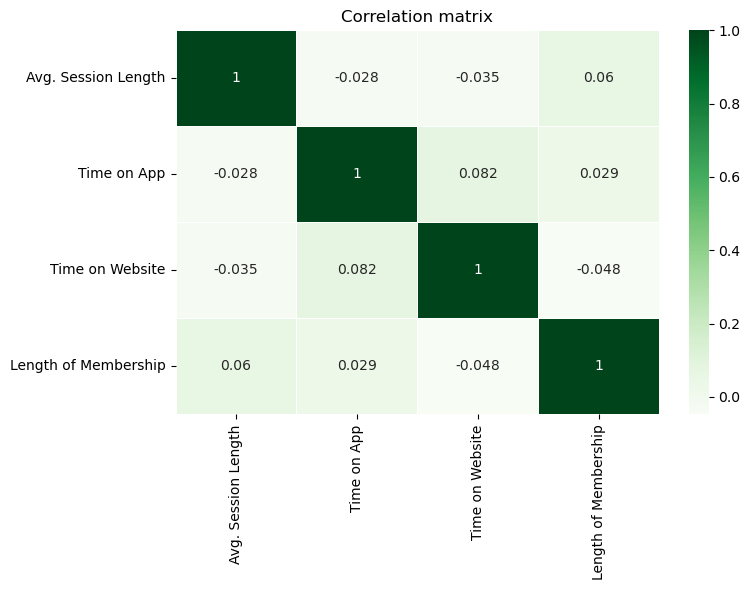

In [11]:
corr_matrix = X.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', linewidths=0.5)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

Since each Pearson correlation coefficient is below 0.3, we can assume that the third assumption of linear regression holds. However, for thoroughness, we will conduct the complete Pearson correlation test.

In [12]:
def calculate_p_values(df):
    
    p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    
    for row in df.columns:
        for col in df.columns:
            if row != col:
                _, p = pearsonr(df[row], df[col])
                p_values.loc[row, col] = p
            else:
                p_values.loc[row, col] = np.nan
    return p_values

p_values = calculate_p_values(X)

print(p_values)

                      Avg. Session Length  Time on App  Time on Website  \
Avg. Session Length                   NaN     0.534750         0.435031   
Time on App                      0.534750          NaN         0.065654   
Time on Website                  0.435031     0.065654              NaN   
Length of Membership             0.178618     0.515592         0.288281   

                      Length of Membership  
Avg. Session Length               0.178618  
Time on App                       0.515592  
Time on Website                   0.288281  
Length of Membership                   NaN  


Since each p-value is larger than 0.05, we lack statistical evidence to reject the null hypothesis, which suggests that there is no correlation between each pair of variables.

We will assess the third and fourth assumptions when we apply regularization to the model at the end.

## 3. Training the model

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state = 4)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 1)

In [14]:
X_train_sm = pd.concat((X_train, X_val))

X_train_sm = sm.add_constant(X_train_sm)

y_train_sm = np.concatenate((y_train, y_val))

model_sm = sm.OLS(y_train_sm, X_train_sm)

results = model_sm.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     6009.
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:54:15   Log-Likelihood:                -1488.1
No. Observations:                 400   AIC:                             2986.
Df Residuals:                     395   BIC:                             3006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1037.9351 

In [15]:
X_test = sm.add_constant(X_test)

y_pred = results.predict(X_test)

mse = np.mean((y_pred - y_test)**2)
r2 = results.rsquared

print(f"MSE: {mse}")
print(f"R^2: {r2}")

MSE: 96.51779453246355
R^2: 0.9838311156025448


The results are very satisfying with a R-squared of 98.38%. However, the model summary suggests that the **Time on Website** variable is not statistically significant. We could simply remove it from the model, but let's see the results of **LASSO** regularization.

## 4. LASSO

Here we use grid search to select the best lambda by testing each LASSO model with validation data.

In [16]:
start = 0.4
stop = 0.8
step = 0.01
lambdas = np.arange(start, stop, step)

coefs = []
aic_values = []

for l in lambdas:
    lasso = Lasso(alpha = l).fit(X_train,y_train)
    coefs.append(lasso.coef_)

    y_pred = lasso.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    n = len(y_val)
    rss = mse * n
    k = np.count_nonzero(lasso.coef_)
    aic = n * math.log(rss / n) + 2 * k
    aic_values.append(aic)

coefficients = np.array(coefs)
aic_values = np.array(aic_values)

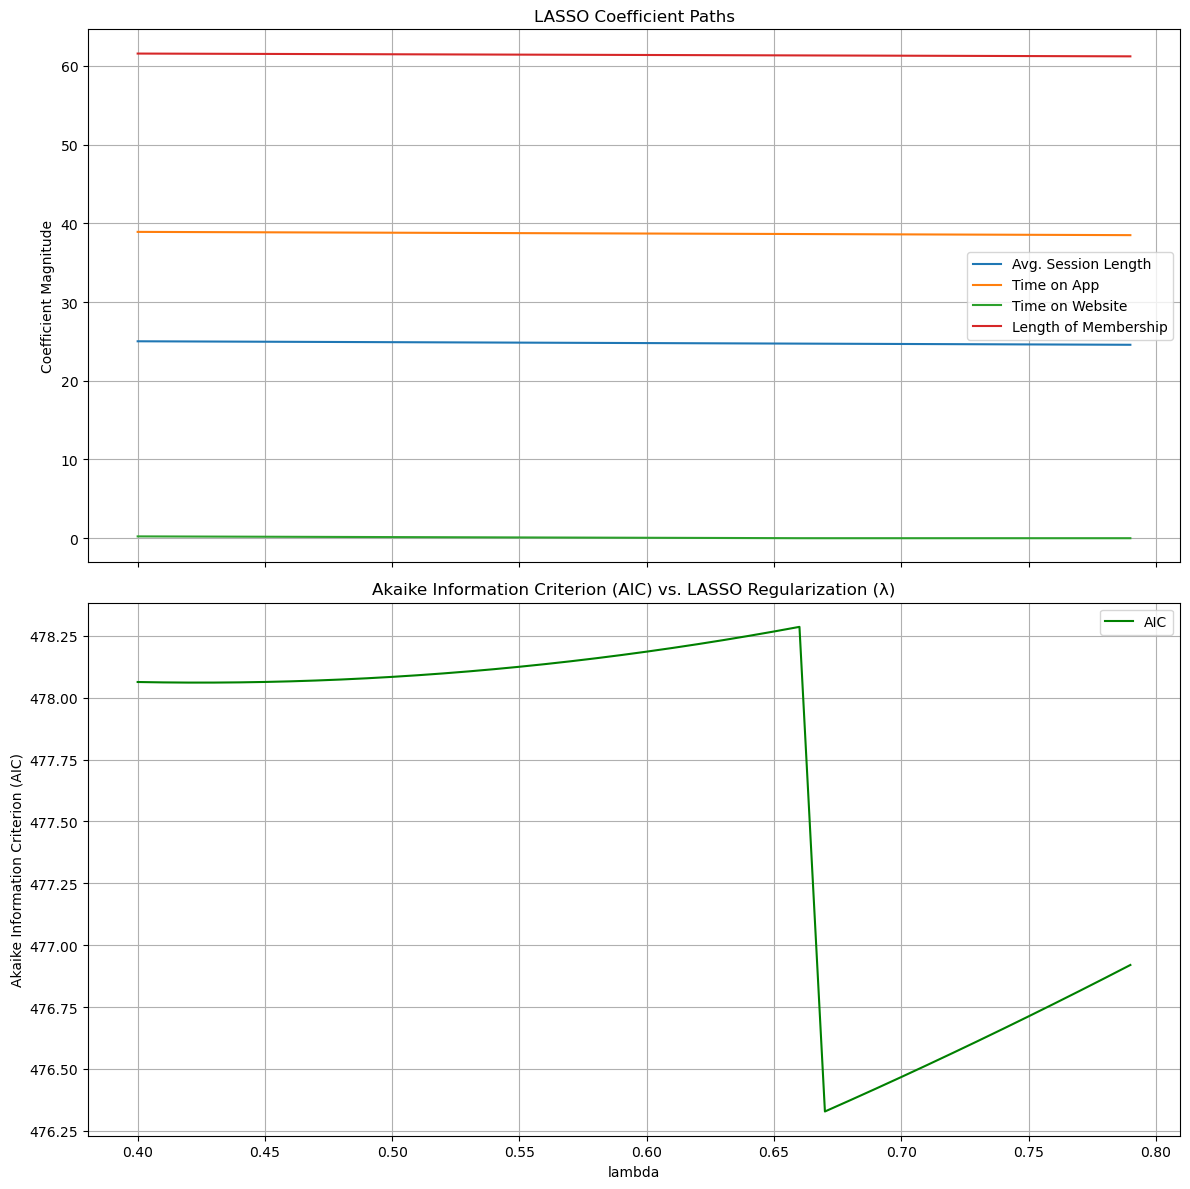

In [17]:
column_names = X.columns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

for feature in range(X.shape[1]):
    ax1.plot(lambdas, coefficients[:, feature], label=column_names[feature])

ax1.set_ylabel('Coefficient Magnitude')
ax1.set_title('LASSO Coefficient Paths')
ax1.legend()
ax1.grid()

ax2.plot(lambdas, aic_values, color='green', label='AIC')
ax2.set_xlabel('lambda')
ax2.set_ylabel('Akaike Information Criterion (AIC)')
ax2.set_title('Akaike Information Criterion (AIC) vs. LASSO Regularization (λ)')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()


In [18]:
l = lambdas[np.argmin(aic_values)]
print(f'Optimal lambda: {l:.2f}')

Optimal lambda: 0.67


In [19]:
lasso_best = Lasso(alpha = l).fit(X_train,y_train)

print("Lasso Coefficients:", lasso_best.coef_)
print("Lasso intercept;", lasso_best.intercept_ )

Lasso Coefficients: [24.70575304 38.6266403   0.         61.31718146]
Lasso intercept; -999.4382250600456


Our assumptions were correct, and LASSO reduced the third independent variable to 0. Now, let's examine our final model.

## 5. Final Linear Regression

In [20]:
X_train_sm.drop(['Time on Website'], axis = 'columns', inplace = True)
X_test.drop(['Time on Website'], axis = 'columns', inplace = True)

In [21]:
model_sm_final = sm.OLS(y_train_sm, X_train_sm)

results_final = model_sm_final.fit()

print(results_final.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     8031.
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:54:16   Log-Likelihood:                -1488.2
No. Observations:                 400   AIC:                             2984.
Df Residuals:                     396   BIC:                             3000.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1035.5394 

After Lasso our current model has a form:

$$\hat{Y} = -1035.54 + 25.52\cdot X_{1} + 39.14\cdot X_{2} + 62.1\cdot X_{3},$$ where 

$X_{1}$ - Avg. Session Length,

$X_{2}$ - Time on App ,

$X_{3}$ - Length of Membership.

In [22]:
y_pred_sm = results_final.predict(X_test)

mse = np.mean((y_pred_sm - y_test)**2)
r2 = results_final.rsquared

print(f"MSE: {mse}")
print(f"R^2: {r2}")

MSE: 96.77470721088658
R^2: 0.9838303835731518


Let's look at our last two assumptions. Firstly, we are going to examine the plot of residuals.

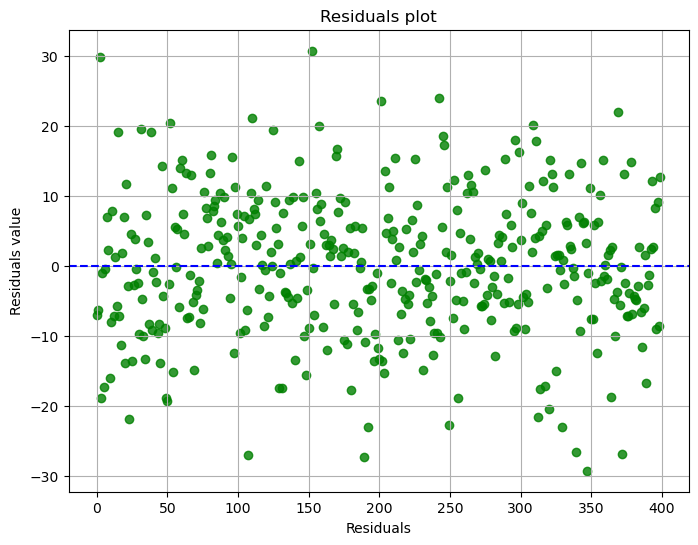

In [23]:
residuals = results_final.resid

plt.figure(figsize=(8, 6))
plt.title('Residuals plot')
plt.scatter(np.arange(len(residuals)), residuals, alpha=0.8, color='g')
plt.axhline(y=0, color='b', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Residuals value')
plt.grid(True)
plt.show()

To check homoscedasticity in residuals, we are going to conduct the Breusch-Pagan test, and for normality, we will use the Shapiro-Wilk test.

In [24]:
_, pval, _, f_pval = het_breuschpagan(residuals, X_train_sm)
print(f'p-value for test BP: {pval:.4f}')
print(f'F statistic: {f_pval:.4f}')

p-value for test BP: 0.1114
F statistic: 0.1118


In [25]:
stat, p_value = stats.shapiro(residuals)
print(f'test statistic: {stat:.4f}')
print(f'p-value: {p_value:.4f}')

test statistic: 0.9972
p-value: 0.7357


As a result, both tests have provided positive results for the model, confirming that all assumptions are met.